# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

In [1]:
# Start with some standard imports.
from os import chdir
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as transforms_F
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import masks_to_boxes

from data_loader import SubsetDataset
from trainer import Trainer


# some utility functions
# sets current directory a the notebook's parent
def make_paths_relative_to_root():
    """Always use the same, absolute (relative to root) paths
    which makes moving the notebooks around easier.
    """
    top_level = Path(__file__).parent
    chdir(top_level)

# functions to show an image
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

#Global setting
BATCH_SIZE = 128
DEVICE = 'cuda:0'

#### Data preparation
I define a custom class `SubsetDataset`, which wraps a `Subset` into a `Dataset` object. This will be useful when we'll want to use a different transformation from training and validation on CIFAR-10.

For MNIST dataset we use the following approach
- Data is normalized using the mean and standard deviation of the dataset and then resized to 32x32, to mantain the same size of CIFAR-10. This resize was also used in the original LeNet paper for convolutional networks, as it helps to enlarge the receptive field of convolutional layers.
- 10% of training data is held out and used for validation.

In [2]:
# Load MNIST train dataset
dataset = datasets.MNIST(root='/data',train=True,download=True)
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # antialias required to not throw a warning
    transforms.Resize(32,antialias=False)
])
# Split train into train and validation. We use 10% of the training data as validation
val_size = int(0.1*len(dataset))
I = np.random.permutation(len(dataset))

mnist_train = SubsetDataset(Subset(dataset, I[val_size:]),transform)
mnist_val = SubsetDataset(Subset(dataset, I[:val_size]),transform)

train_data_loader = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True)
valid_data_loader = DataLoader(mnist_val,batch_size=BATCH_SIZE)

Let's verify that the data is loaded correctly by plotting some images.

torch.Size([128, 1, 32, 32]) torch.Size([128])


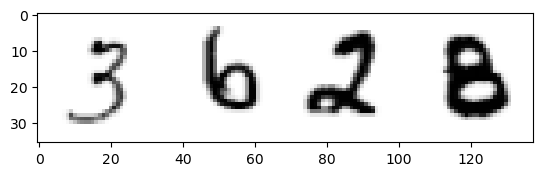

In [3]:
dataiter = iter(train_data_loader)
images,labels = next(dataiter)
# revert standardization
# images = images*0.3081 + 0.1307
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4],vmin=0,vmax=1),one_channel=True)

#### Training and evaluation code

I will use WandB to log all the experiments.
MLP experiments are available [here](https://wandb.ai/dla-darcio/lab-1-mlp)

In [4]:
wandb.login()

wandb_config = {
    "project":"lab-1",
    "job_type": "model_trainer",
    "dataset_name": "mnist",
    "model_collection_name": "MNIST MLP"
}

wandb: Currently logged in as: dario-cioni (dla-darcio). Use `wandb login --relogin` to force relogin


I defined a custom [Trainer](trainer.py) class to handle the training and validation loop.
The `Trainer` will contain all the training logic, for simplicity we fixed the following parameters:
- Loss will be always categorical cross-entropy and will be logged during training and validation
- Top-1 accuracy will be logged during model training and validation
- Model's gradients will be also logged during training by WandB utility `wandb.watch`.

### MLP definition
Here I define a MLP class, which allows to specify the dimension of each layer by passing an array
```python
model_mlp = MLP([768,16,16,10])
```

In [5]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for (in_dim,out_dim) in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = x.view(x.shape[0],-1)
        out = self.layers(out)
        return out

### Training configuration

To allow faster experimentation, all the configuration is defined through dictionaries and then logged into WandB.

For the MNIST MLP
- I trained the network for 30 epochs with a learning rate of $10^{-4}$ using Adam optimizer.
- Batch size is 128

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Training

In [6]:
INPUT_SIZE = 32*32

# Training hyperparameters.
trainer_hparams={
    "epochs":30,
    "lr":0.0001,
    "batch_size":128
}

# Architecture hyperparameters.
arch_hparams={
    "width":100,
    "depth":2
}

config = {**trainer_hparams,**arch_hparams}
print(config)

writer = wandb.init(project=wandb_config['project'],config=config)
# Define a DataLoader for MNIST with train and validation split

# Instantiate model and optimizer.
config = writer.config
model_mlp = MLP([INPUT_SIZE] + [config.width]*config.depth + [10]).to(DEVICE)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)
# Begin training
trainer = Trainer(opt,writer,epochs=config.epochs,device=DEVICE, checkpoints=True, **wandb_config)
trainer.train(model_mlp,train_data_loader,valid_data_loader)

{'epochs': 30, 'lr': 0.0001, 'batch_size': 128, 'width': 100, 'depth': 2}


Epoch 30: 100%|█████████▉| 420/422 [00:13<00:00, 33.52it/s, step_acc=0.609, step_loss=0.963, train_acc=0.603, train_loss=0.958, valid_acc=0.601, valid_loss=0.976]

Epoch 30: 100%|██████████| 422/422 [00:25<00:00, 33.52it/s, step_acc=0.609, step_loss=0.963, train_acc=0.603, train_loss=0.958, valid_acc=0.601, valid_loss=0.976]

train_accuracy,▄▃▁▄▅▂▅▅▃▆▂▄▄▅▇▄▇▄▅▄▇▅▆▅▅▄▄▇█▅▄▁▇▅▇▆▄▄▅█
train_loss,█▆▆▄▃▅▃▃▄▂▄▄▃▃▁▄▂▃▃▄▂▂▂▃▂▃▃▂▁▃▄▄▂▃▂▂▃▃▂▁
val_acc,▁▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇█████
val_loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,0.60938
train_loss,0.96338
val_acc,0.6015
val_loss,0.97484


([(1.6135972554649787, 0.5272592306137085),
  (1.1540872100122732, 0.5812963247299194),
  (1.0972524324864572, 0.5849259495735168),
  (1.0745862212508777, 0.5869629383087158),
  (1.0609674248932661, 0.5886296033859253),
  (1.050681503180644, 0.5896296501159668),
  (1.0420208831816489, 0.5909073948860168),
  (1.03450678917469, 0.5918889045715332),
  (1.028252480295597, 0.5927963256835938),
  (1.021799396423367, 0.5935184955596924),
  (1.0165274961017319, 0.5943703651428223),
  (1.011534440715166, 0.5951296091079712),
  (1.0067285655234097, 0.5958518385887146),
  (1.002290739691088, 0.5965555310249329),
  (0.9983028245480705, 0.5971296429634094),
  (0.9944214607584533, 0.5977592468261719),
  (0.9904675822687375, 0.598370373249054),
  (0.9876074988695117, 0.5988518595695496),
  (0.9840541121801494, 0.5990740656852722),
  (0.9806304133333866, 0.599574089050293),
  (0.9782472918101397, 0.6000185012817383),
  (0.9752275001663733, 0.6001481413841248),
  (0.9727127735648675, 0.6008333563804626

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#### CIFAR-10 Data preparation
Here I define my dataset for CIFAR-10. Input images are per-pixel normalized along every channel. Mean and std are computed with the following code

In [7]:
# Load CIFAR train set
cifar_ds = datasets.CIFAR10(root='/data',train=True,download=True)
# Compute mean and std
mean = np.mean(cifar_ds.data, axis=(0,1,2))/255
std = np.std(cifar_ds.data, axis=(0,1,2))/255
print(f"Mean: {mean} - std: {std}")

Files already downloaded and verified
Mean: [0.49139968 0.48215841 0.44653091] - std: [0.24703223 0.24348513 0.26158784]


Data augmentation is performed as in the paper
- The 32x32 is padded with 4 pixel on each side
- A random crop of 32x32 is taken from the padded image or its horizontal flip

Validation is 10% of training dataset. On this set, I only perform per-pixel normalization

In [8]:
# normalize data based on train split
normalize = transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
# Data augmentation and normalization for training
# Just normalization for validation
transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]),
}

# Split train into train and validation.
val_size = int(0.1 * len(cifar_ds))
I = np.random.permutation(len(cifar_ds))
cifar_train = SubsetDataset(Subset(cifar_ds, I[val_size:]), transform['train'])
cifar_val = SubsetDataset(Subset(cifar_ds, I[:val_size]), transform['val'])

cifar_train_loader = DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True)

To make sure that the the images and labels are in the correct format let's display a few samples. We can see that the images are not centered anymore, because of the data augmentation procedure we used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32]) torch.Size([128])


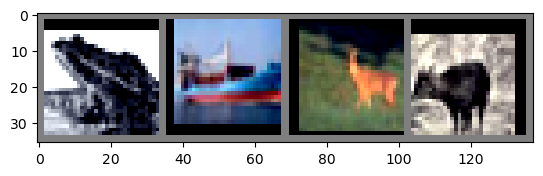

In [9]:
dataiter = iter(cifar_train_loader)
images,labels = next(dataiter)
# images = images * std[:,None,None] + mean[:,None,None]
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]))

Here I define the convolutional network, which follows the ResNet definition of the paper for CIFAR-10.
The network is composed by an initial $3\times3$ convolutional layer, followed by a stack of $6n$ layers with $3 \times 3$ convolutions on feature maps of sizes {32,16,8}, with $2n$ layers for each feature map size.
The number of filters is doubled every time the size of the feature map is halved, to mantain the same number of operations.


| Output map size | 32 x 32 | 16 x 16 | 8 x 8 |
|-----------------|---------|---------|-------|
| # layers        | 1 + 2n  | 2n      | 2n    |
| # filters       | 16      | 32      | 64    |

#### Residual Block
To allow an easy modification of the model's depth and enabling/disabling residual connections, I created a `ResidualBlock` Module, which allows to add blocks of two convolutional layers to the network.
- The block consists of two convolutional layers, each followed by a Batch Normalization Layer before the ReLU activation.
- Downsampling is obtained with a strided convolution performed by the first convolutional layer.
- The residual connection is obtained by summing the input feature maps before the second nonlinearity. Since summmation is allowed only if the feature maps have the same shape, a projection layer is added to the residual connection when downsampling is performed.

#### Projection
The paper experiments with three types of projection. I provide an implementation of all three
    A) Parameter-free projection, performed by downsampling the input feature map and padding the remaining channels with zeros
    B) Paremeterized projection with an affine trasformation, followed by a Batch Normalization layer.
    C) Add a parameterized projection to all residual connections

#### Global Average Pooling
The ResNet use a Global Average Pooling layer followed by a Fully connected layer, as defined in [[2](https://arxiv.org/pdf/1312.4400.pdf)]. The Global Average Pooling transforms a feature map $H \times W \times C$ into $1 \times 1 \times C$.
If $C = $ num_classes, the resulting tensor could be directly fed into a softmax for prediction, however we employ a single Fully Connected layer, as done in the paper.

#### Initialization


In [10]:
class DownsampleA(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        d = self.downsample(x)
        # Here I assume stride is only 2.
        out = torch.concat([d, torch.zeros_like(d)], dim=1)
        return out


class DownsampleB(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.downsample(x)
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, residual=True, residual_type='b', stride=1, batchnorm=True):
        super().__init__()
        self.residual = residual
        self.batchnorm = batchnorm
        self.stride = stride
        if residual:
            self.residual_type = residual_type.lower()
            if self.residual_type == 'a' and (in_channels != out_channels or stride > 1):
                self.project = DownsampleA(in_channels, out_channels, stride)
            if self.residual_type == 'b' and (in_channels != out_channels or stride > 1):
                self.project = DownsampleB(in_channels, out_channels, stride)
            if self.residual_type == 'c':
                self.project = DownsampleB(in_channels, out_channels, stride)
        # vgg has strided conv instead of maxpool
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride,
                               bias=(not self.batchnorm))
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=(not self.batchnorm))
        if self.batchnorm:
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # first conv
        out = self.conv1(x)
        if self.batchnorm:
            out = self.bn1(out)
        out = F.relu(out)
        # second conv
        out = self.conv2(out)
        if self.batchnorm:
            out = self.bn2(out)
        # residual connection
        if self.residual:
            res = x if x.shape == out.shape else self.project(x)
            out += res
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, layers, residual=False, residual_type='b', num_channels=16, batchnorm=True,grayscale=False):
        super().__init__()
        self.residual = residual
        self.batchnorm = batchnorm
        self.residual_type = residual_type if residual else None
        in_channels = 1 if grayscale else 3

        self.conv1 = nn.Conv2d(in_channels, num_channels, 3, padding=1, bias=(not self.batchnorm))
        if self.batchnorm:
            self.bn1 = nn.BatchNorm2d(num_channels)
        # stack 3 convolutional block of 2n layers each, with first block performing a downsampling (only in 2nd and 3rd layer for CIFAR)
        self.layer1 = self._add_block(in_channels=num_channels, out_channels=num_channels, n_blocks=layers[0], stride=1)
        num_channels *= 2
        self.layer2 = self._add_block(num_channels // 2, num_channels, layers[1], stride=2)
        num_channels *= 2
        self.layer3 = self._add_block(num_channels // 2, num_channels, layers[2], stride=2)
        self.num_channels = num_channels

    def _add_block(self, in_channels, out_channels, n_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, self.residual, self.residual_type, stride=stride,
                                    batchnorm=self.batchnorm))
        in_channels = out_channels
        for i in range(1, n_blocks):
            layers.append(
                ResidualBlock(in_channels, out_channels, self.residual, self.residual_type, batchnorm=self.batchnorm))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.batchnorm:
            out = self.bn1(out)
        out = F.relu(out, inplace=True)
        # print(out.shape) # 128,16,32,32
        out = self.layer1(out)
        # print(out.shape) # 128,32,16,16
        out = self.layer2(out)
        # print(out.shape) # 128,32,8,8
        out = self.layer3(out)
        # print(out.shape) # 128,64,4,4
        # print(out.shape)
        return out


class ResNetForClassification(ResNet):
    def __init__(self, num_classes: int = 10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.num_channels, num_classes)

    def forward(self, x):
        out = super().forward(x)
        # print(out.shape) # 128,64,4,4
        out = self.avgpool(out)
        # print(out.shape) # 128,64,1,1
        out = torch.flatten(out, 1)
        # print(out.shape) # 128,64
        out = self.fc(out)
        return out

#### Training
We can now train convolutional models with and without residual connections.
- Used SGD optimizer, since it usually allows better results [[1](https://arxiv.org/pdf/1705.08292.pdf)], but needs to be trained for more epochs than Adam.
- Following the paper, I used a momentum of 0.9 and a weight decay of $10^{-4}$.
- The learning rate is initially set as 0.1 and divided by 10 at epochs 50 and 75, and training ends at epoch 85.

We train four models, with 3 and 9 blocks per layer, leading to 20 and 56 layer architectures, with and without residual connections.
Training logs are available [here](https://wandb.ai/dla-darcio/lab-1-resnets) or by executing in terminal:

```bash
wandb dla-darcio/lab-1-resnets
```

#### Experimental results

We can see that the 56-layer network without residual connections obtains a lower validation accuracy than the 20-layer plain net (-4.5%).
Both the 20-layer and the 56-layer residual network obtain a higher validation accuracy compared to the plain networks, with the 56-layer residual network leading to the best accuracy, with a slight increase with respect to the 20-layer residual network (+0.3%).

<img src="./assets/Plain_Res_accuracy.png"  width="1600" height="800">

#### We need to go deeper
As stated by the famous [meme](https://knowyourmeme.com/memes/we-need-to-go-deeper), I tried additional, deeper configurations, such as a 101-layer configuration and a 152-layer configuration.
In this case we can see that the 56-layer and the 101-layer configuration achieve similar results, with the 101-layer configuration leading to a slightly better accuracy (+0.2%).
The 152-layer configuration, however, leads to a lower accuracy than the 56-layer configuration (-0.5%).


<img src="./assets/Deep_Res_accuracy.png"  width="1600" height="800">

Looking at the loss on the validation set, we see that for 101-layer and 152-layer configuration the loss starts to rise again after a certain number of epochs, which is a sign of overfitting.
We can thus attribute the lower accuracy of the 152-layer configuration to overfitting.


<img src="./assets/deep_res_loss.png"  width="1600" height="800">

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

#### Wandb logs
WandB allowed to log the gradients flowing through the network during training.
We can see that the gradients flowing through the residual network are much higher than the gradients flowing through the plain network.

Taking for example the gradients in the first convolutional layer of each block, we can see that the gradients flowing through the residual network are about 10 times higher than the gradients flowing through the plain network.

<img src="./assets/grad_flow.png"  width="1600" height="800">

#### Plain network

In [11]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharex=False,sharey=False)

    for n, p in named_parameters:
        if(p.requires_grad) and "conv" in n:

            grad_norm = torch.nn.utils.clip_grad_norm_(p, torch.inf, norm_type=2)
            # print(grad_norm)
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(grad_norm)
    ax1.plot(np.arange(len(max_grads)), max_grads, lw=1, color="r")
    ax2.plot(np.arange(len(ave_grads)), ave_grads, lw=1, color="b")
    # plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    # plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    # ax1.xlim(left=0, right=len(layers))
    # ax1.set_xlim(25,len(layers)) # zoom in on the lower gradient regions
    # ax2.set_xlim(25,len(layers)) # zoom in on the lower gradient regions
    # ax1.set_ylim(top=0.01) # zoom in on the lower gradient regions
    # ax2.set_ylim(top=0.01) # zoom in on the lower gradient regions
    ax1.set_xlabel("Layers")
    ax1.set_ylabel("max gradient")
    ax2.set_ylabel("average gradient")
    # fig.set_title("Gradient flow")
    plt.grid(False)
    # plt.legend(['max-gradient', 'mean-gradient', 'zero-gradient'])



#### Residual network


### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

#### MNIST Object localization
This experiment uses a fully-convolutionalized ResNet to perform **object localization** on MNIST. This was chosen over **detection** since it and could not use the same training procedure as before, and would require an approach which evaluates both precision and recall and requires more hyperparameters to tune (e.g the threshold for the detection).

#### Fully-convolutional model definition
To make a fully-convolutional model, I only changed two things:
- Associate one feature map to each model class. To achieve this, we can use a 1x1 convolution to pass from 64 to 10 feature maps for MNIST and CIFAR-10
- Removed the last fully-connected layer and replaced it with a $1x1$ global average pooling layer.
- Use a Global Average pooling to calculate the spatial average of each feature map

I created a new class `FullyConvResNet` that inherits from `ResNet`, which defines two methods:
- A standard `forward` method to perform classification
- A localize method to perform classification + localization.

The localization method generates a feature map of dimension $(mapping_size \times mapping_size)$, which is then transformed into a map of pixel-level probabilities of each class using a 2d softmax function.
Since the network performs downsampling of the input image, this map is smaller than the input image, so that each element in this map is associated to a region of the input image.

In [12]:
class FullyConvResNet(ResNet):
    def __init__(self, num_classes: int = 10, mapping_size = 16, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.project = nn.Conv2d(self.num_channels,num_classes,1)
        self.classifier = nn.AdaptiveAvgPool2d(1)
        # Someway limits
        self.map = nn.AdaptiveAvgPool2d(mapping_size)
        self.s2d = nn.Softmax2d()

    def forward(self, x):
        out = super().forward(x)
        # print(out.shape) # 128,64,4,4
        out = self.project(out)
        # print(out.shape) # 128,10,4,4
        logits = self.classifier(out)
        # print(out.shape) # 128,10,1,1
        return logits.squeeze()

    def localize(self, x):
        out = super().forward(x)
        out = self.project(out)
        # compute classification
        logits = self.classifier(out)
        # compute activation map
        mapping = self.map(out)
        return logits, self.s2d(mapping)

torch.Size([128, 1, 32, 32]) torch.Size([128])


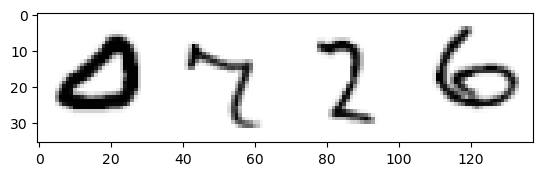

In [13]:
dataiter = iter(train_data_loader)
images,labels = next(dataiter)
# images = images * std[:,None,None] + mean[:,None,None]
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]),one_channel=True)

#### Data Loading


In [14]:
AUG_SIZE = 128

def embed_image(img):
    imgs, labels = torch.utils.data.default_collate(img)
    batch_size,channels = imgs.shape[0:2]
    new_img = torch.zeros((batch_size,channels,AUG_SIZE, AUG_SIZE))
    x_min, y_min = randrange(AUG_SIZE - imgs.shape[2]), randrange(AUG_SIZE - imgs.shape[3])
    x_max, y_max = x_min + imgs.shape[2], y_min + imgs.shape[3]
    new_img[:,:,x_min:x_max, y_min:y_max] = imgs
    # print(new_img.shape)
    return new_img, labels #(x_min, y_min, x_max, y_max)

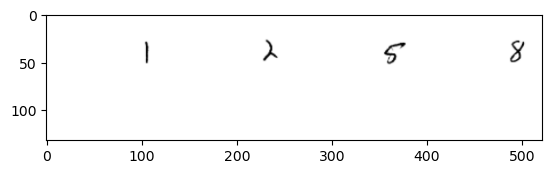

In [15]:
train_data_loader = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,collate_fn=embed_image)
valid_data_loader = DataLoader(mnist_val,batch_size=BATCH_SIZE,collate_fn=embed_image)

dataiter = iter(train_data_loader)
images,labels = next(dataiter)
images, labels = images[0:4], labels[0:4]

imshow(torchvision.utils.make_grid(images),one_channel=True)

In [16]:
wandb.login()

wandb_config = {
    "project":"lab-1",
    "job_type": "model_trainer",
    "dataset_name": "MNIST-Localization",
    "model_collection_name": "MNIST Fully-conv ResNet"
}

# Training hyperparameters.
optimizer_hparams={
    "lr":1e-3
    #"weight_decay": 1e-4,
}

# Architecture hyperparameters.
arch_hparams={
    "layers":[1]*3,
    "residual": True,
    "num_classes":10,
    "num_channels": 16,
    "residual_type": 'a',
    "grayscale": True
}

config = {
    "optimizer": "Adam",
    "epochs":5,
    **optimizer_hparams,
    **arch_hparams
}

# Initialize WandB logging all hyperparameters
writer = wandb.init(project=wandb_config['project'],config=config)
config = wandb.config

# Initialize model
model = FullyConvResNet(**arch_hparams).to(DEVICE)
print(model)

# Get optimizer from torch.optim
opt = getattr(torch.optim,config.optimizer)(params=model.parameters(), **optimizer_hparams)

# Begin training
trainer = Trainer(opt,writer,epochs=config.epochs,device=DEVICE,checkpoints=True, **wandb_config)
trainer.train(model,train_data_loader,valid_data_loader)

C:\Users\Dario\mambaforge\envs\pytorch-lightning\lib\site-packages\wandb\sdk\wandb_run.py:2087: UserWarning: Run (5dkpyj7y) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
Epoch 30: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s, step_acc=0.609, step_loss=0.963, train_acc=0.603, train_loss=0.958, valid_acc=0.601, valid_loss=0.976]


FullyConvResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (project): DownsampleA(
        (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
      )
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-

Epoch 5: 100%|██████████| 422/422 [01:37<00:00,  4.43it/s, step_acc=0.977, step_loss=0.0903, train_acc=0.982, train_loss=0.0871, valid_acc=0.882, valid_loss=0.385]

train_accuracy,▁▂▄▆▆▇▇▇█▇██████████████████████████████
train_loss,█▇▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅█▃▇▁
val_loss,▃▁▄▁█
train_accuracy,0.97656
train_loss,0.09029
val_acc,0.5155
val_loss,1.66188


([(1.2133382493850744, 0.7354074120521545),
  (0.2579140320985238, 0.9657777547836304),
  (0.12683238000807603, 0.9765185117721558),
  (0.0871188564323136, 0.9818703532218933),
  (0.06792720695913403, 0.984499990940094)],
 [(0.7449603385113656, 0.7666666507720947),
  (0.31369887165566707, 0.9114999771118164),
  (0.9773796441707205, 0.6016666889190674),
  (0.3847044459048738, 0.8820000290870667),
  (1.6618803866366123, 0.515500009059906)])

#### Localization
To perform localization with the trained classifier, we choose the feature map associated to the class with highest probability and use it to generate a heatmap of the same size as the input image.
Since the network performs downsampling during the forward pass, the mapping_size is smaller than the image size. To obtain the bounding box coordinates, we should associate each pixel of this probability map to a set of pixel in the original image.

To simplify this process, I just performed a bicubic interpolation, resizing the heatmap to the original image size. This is not the best solution, but it is a working approximation.

The plotted images should resemble a heatmap of the predicted probability for each pixel.

torch.Size([4, 1, 16, 16])


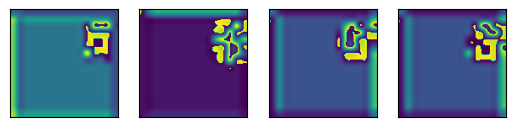

In [17]:
logits, map = model.localize(images.to(DEVICE))


# cam = s2d(F.adaptive_avg_pool2d(output,(32,32)))
# logits = F.adaptive_avg_pool2d(output,(1,1))
class_pred = torch.argmax(logits.squeeze(),dim=1)


# seg_map = cv2.threshold(
#     map[:,class_pred,:,:],0.9,1.,cv2.THRESH_BINARY
# )

masks = []
for i,c in enumerate(class_pred):
    masks.append(map[i,c.item(),:,:])
masks = torch.stack(masks).unsqueeze(1)
print(masks.shape)

# seg_map = seg_map.unsqueeze(0).unsqueeze(0)

resize = torchvision.transforms.Resize(AUG_SIZE, interpolation=InterpolationMode.BICUBIC, antialias=True)

t = transforms.ToPILImage()

masks = resize(masks).detach().cpu()

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach()
        img = transforms_F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(masks)
masks = (masks > 0.8).type(torch.uint8)

#### Bounding Box
To transform the heatmap into a bounding box, we set a threshold, to transform the heatmap into a binary mask.
We can then use the `masks_to_boxes` function from `torchvision.ops`. This function returns the coordinates of the bounding box that contains the mask.

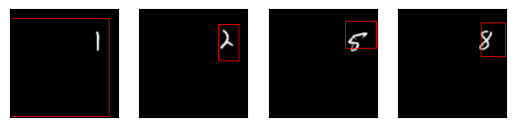

In [18]:
boxes = masks_to_boxes(masks.squeeze())

drawn_boxes = []
for i in range(images.shape[0]):
    img = images[i]
    img = img * 255
    drawn_boxes.append(draw_bounding_boxes(img.type(torch.uint8), boxes[i].unsqueeze(0), colors="red"))
show(drawn_boxes)

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

In [19]:
# Your code here.


## References
- [1] Ashia C. Wilson, Rebecca Roelofs, Mitchell Stern, Nathan Srebro, and Benjamin Recht. The Marginal Value of Adaptive Gradient Methods in Machine Learning, 2018.
- [2] Lin, Min, Qiang Chen, and Shuicheng Yan. "Network in network." arXiv preprint arXiv:1312.4400 (2013).